In [2]:
import environment.utils as utils
import numpy as np

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
market_price = 138/10000  # Example market price
T = 2.0  # Time to expiry (years)
K = 0.04259 - 100/10000  # Strike rate
R = 0.04259  # Forward swap rate

# Example OIS rates and maturities
maturities = [3, 4]  # Payment dates (years)
ois_rates = [0.03, 0.032]  # Corresponding OIS zero rates (3% and 3.2%)


S = 0.866+0.897-0.2

def black_price_swaption(sigma, T, K, S, R, option_type='payer'):
    """
    Black formula for European swaptions including the annuity factor.
    
    Parameters:
        sigma (float): Black implied volatility
        T (float): Time to expiration (years)
        K (float): Strike rate
        S (float): Present value of the fixed leg annuity
        R (float): Forward swap rate
        option_type (str): 'payer' or 'receiver'
    
    Returns:
        float: Black swaption price
    """
    if T == 0:
        return S * max(0, (R - K) if option_type == 'payer' else (K - R))
    
    d1 = (np.log(R / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'payer':
        price = S * (R * norm.cdf(d1) - K * norm.cdf(d2))
    else:  # Receiver swaption
        price = S * (K * norm.cdf(-d2) - R * norm.cdf(-d1))
    #print(sigma, price)
    return price

black_price = black_price_swaption(0.2, T, K, S, R, option_type='payer')

loss = black_price - market_price
print(loss)

0.003339365941290171


In [4]:
from scipy.stats import norm

# Given market data
F = 0.042  # 2y2y forward swap rate (4.2%)
K = 0.042  # Assume ATM strike at the forward swap rate
T = 2.0  # Time to expiry (2 years)
sigma_annualized = 0.2504  # ATM Black volatility (25% per annum)

# Convert annualized volatility to Black model usable volatility
sigma = sigma_annualized * np.sqrt(T)

# Black's formula for swaption pricing
def black_swaption_price(F, K, T, sigma, option_type="payer"):
    """ Computes Black's model price for a European swaption """
    if K <= 0:  # Strike must be positive
        return 0

    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "payer":
        price = F * norm.cdf(d1) - K * norm.cdf(d2)
    else:  # receiver swaption
        price = K * norm.cdf(-d2) - F * norm.cdf(-d1)
    
    return max(price, 0)  # Prices cannot be negative

# Compute ATM swaption prices
payer_swaption_price = black_swaption_price(F, K, T, sigma, "payer")
receiver_swaption_price = black_swaption_price(F, K, T, sigma, "receiver")

payer_swaption_price*10000, receiver_swaption_price*10000


(83.04322756162958, 83.04322756162955)

In [5]:
utils.Utils(init_ttm=30, np_seed=42, num_sim=1).get_sim_path_sabr()

Generating asset price paths (SABR)
Generating implied vol


/home/hedge/gamma-vega-rl-hedging/environment/utils.py:222: RuntimeWarning: invalid value encountered in divide
  SABRIV = np.where(F == self.K, vol * B / (F ** (1 - self.beta)), A * B * Phi / Chi)


(array([[10.        , 10.06197772, 10.04296461, 10.12764548, 10.32153278,
         10.29114754, 10.26169392, 10.45841478, 10.54621665, 10.4944552 ,
         10.55407458, 10.50179248, 10.4486535 , 10.47552672, 10.26275744,
         10.07270636, 10.00952316,  9.89700407,  9.93285144,  9.8269692 ,
          9.66876354,  9.83928494,  9.81336814,  9.82020302,  9.66128333,
          9.5967801 ,  9.60948768,  9.47343495,  9.51759374,  9.4452735 ,
          9.40844197]]),
 array([[0.19968929, 0.20832879, 0.20847564, 0.20086791, 0.20122963,
         0.19535005, 0.19685864, 0.1835669 , 0.17578501, 0.17754212,
         0.1795886 , 0.18125446, 0.18161865, 0.17957959, 0.17687647,
         0.17733034, 0.1763165 , 0.18383763, 0.18464516, 0.17796977,
         0.18308029, 0.17743195, 0.17455943, 0.17722682, 0.18600517,
         0.1922964 , 0.18736749, 0.18874888, 0.18934142, 0.19627689,
         0.19428974]]))

In [6]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm



def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [7]:
path_params = os.path.join(os.getcwd(), "parameters")
forwards = load_object(path_params+"/spot_forwards.pkl")
s0_exp = load_object(path_params+"/vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"/volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"/fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"/volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"/fwdvol_corr.pkl")
params_g = load_object(path_params+"/vol_params_g.pkl")
params_h= load_object(path_params+"/volvol_params_h.pkl")
spots= load_object(path_params+"/spot_rates.pkl")

epsilon_exp = np.concatenate([epsilon_exp[[0]],epsilon_exp])
s0_exp = np.concatenate([s0_exp[[0]], s0_exp])

20


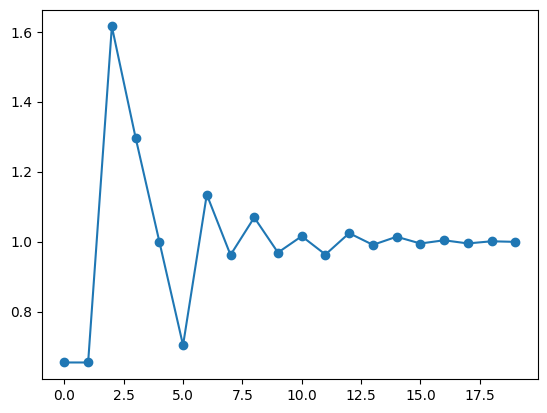

In [8]:
rho_mat_6m = doust_fwd_fwd[:19, :19]
theta_mat_6m = doust_vol_vol[:19, :19] #TODO: check if this is correct, or it should remove the first row and column instead
phi_mat = corr_fwd_vol
fwd_tenors = np.arange(1,10.5,0.5)

plt.plot(s0_exp, 'o-')
print(len(s0_exp))

In [9]:
beta_6m = 0.20696204
beta_0m = 0.25697769
beta_theta_0m = 0.1556888
beta_theta_6m = 0.12135651
n=20
tau = np.arange(0, n+1)/2


def doust_corr(beta, n):
    '''
    create nxn doust correlation with beta decay exponential
    n = # of semi-annual expiries
    '''
    tau = np.arange(0, n+1)/2 # start from spot
    a = np.exp(- beta / np.arange(1, len(tau[:-1])+1) )
    doust = np.zeros((n, n))
    dim = doust.shape
    for i in range(doust.shape[0]):
        for j in range(doust.shape[1]):
            if i == j:
                doust[i, j] = 1
            elif i > j:
                doust[i, j] = np.prod(a[j:i])
    #reflect
    doust[np.triu_indices(dim[0], 1)] = doust.T[np.triu_indices(dim[0], 1)]
    return(doust)

rho_mat_0m = doust_corr(beta_0m, n)
theta_mat_0m = doust_corr(beta_theta_0m, n)
assert rho_mat_6m.shape[0] == rho_mat_0m.shape[0]-1, f"{rho_mat_6m.shape[0]-1} != {rho_mat_0m.shape[0]}"
assert theta_mat_6m.shape[0] == theta_mat_0m.shape[0]-1

In [10]:
#reduce ranking
import numpy as np

def reduceRank(corr_matrix, no_of_factors):
    """
    Optimized function to reduce the correlation matrix rank 
    using the eigenvalue zeroing technique.
    """
    # Perform SVD
    Q, lambda_, Vt = np.linalg.svd(corr_matrix)

    # Construct the reduced-rank matrix
    H = np.diag(np.sqrt(lambda_[:no_of_factors]))
    B = Q[:, :no_of_factors] @ H
    reduced_cov_matrix = B @ B.T

    # Convert to correlation matrix efficiently
    std_devs = np.sqrt(np.diag(reduced_cov_matrix))
    reduced_corr_matrix = reduced_cov_matrix / np.outer(std_devs, std_devs)

    return B, reduced_corr_matrix


In [11]:
def drawRandomNumbers (no_of_factors , cholesky):
    '''
    Draw a set of random numbers.
    @var no_of_factors: number of factors that we want
    to employ.
    @var cholesky: Cholesky decomposition of the
    correlation matrix describing the correlation
    among the random variables to simulate.
    '''
    if no_of_factors > 1:
        rand = np.random.normal(size = no_of_factors)
        return cholesky.dot(rand)
    else:
        return np.random.normal ()


def get_instant_vol_func(tau , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    tau = np.maximum(tau, 0)
    a,b,c,d = params
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol


from functools import partial
from scipy import interpolate, stats, integrate, optimize




In [12]:

path = os.path.join(os.getcwd(), "raw_dataset")
df_cap = pd.read_excel(path+"/caplet_raw.xlsx", sheet_name = 2, header = 0)
df_raw_spot = pd.read_csv(path+"/spot.csv")
df_raw_spot["Tenor"] = np.array([1/12, 2/12, 3/12, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 20, 30, 50])

In [13]:
df_raw_spot

,Tenor,Spot,1 Mo (P),6 Mo (P),1 year,1.5 year,2 year
0,0.083333,0.23973,0.23944,0.20286,0.24468,0.24741,0.34224
1,0.166667,0.23961,0.22815,0.20505,0.25238,0.25312,0.34684
2,0.250000,0.23200,0.24283,0.20398,0.24802,0.25589,0.33930
3,0.500000,0.23178,0.22563,0.20681,1.29152,1.30326,1.31498
4,0.750000,0.22252,0.21867,0.22054,1.29152,1.30326,1.31498
5,1.000000,0.21930,0.21971,0.22761,0.24468,0.24741,0.34224
6,2.000000,0.23630,0.24085,0.26709,0.25238,0.25312,0.34684
7,3.000000,0.28405,0.29273,0.34024,0.24802,0.25589,0.33930
8,4.000000,0.36550,0.37661,0.43955,0.52949,0.63186,0.74668
9,5.000000,0.46700,0.48010,0.55030,1.42169,1.44287,1.46405


In [14]:





def create_df_init(df_cap, df_raw_spot, resolution, tau=0.5):

    # Get the LIBOR 6-month spot rate
    libor_6m_spot = df_raw_spot.loc[df_raw_spot["Tenor"] == 0.5, "Spot"].iloc[0] # floating point comparison only safe due to 0.5 bein representable with 2**-1

    # Create a dataframe with the initial values for the spot rate
    spot_row = pd.DataFrame({
        'Fixing': [0.0],
        'Reset Rate': [libor_6m_spot],  # Convert back to percentage
        'Maturity': [0.5]
    })

    # Initialize df_init with df_cap data
    df_full = df_cap[['Fixing', 'Reset Rate', 'Maturity']].copy()

    # Concatenate with the spot rate row and reset index
    df_full = pd.concat([spot_row, df_full], ignore_index=True)
    df_full['Reset Rate'] = df_full['Reset Rate'] / 100  # Convert to percentage


    # =============================================================================
    #                               TIME INDEXING
    # =============================================================================
    ts_fwd_expiry = df_full['Fixing'].values

    dt = tau / resolution
    ids_fwd_interp = (ts_fwd_expiry / dt).astype(int) # divide by dt to get indices in the new time unit
    
    
    n_fwd = len(ts_fwd_expiry)-1 # exclude period covering the last forward rate tenor
    ts_fwd_interp= np.linspace(0, n_fwd*tau, int(n_fwd * resolution +1))
    print(f"{ts_fwd_interp=}")
    assert np.all(np.isin(ts_fwd_expiry, ts_fwd_interp)), "Not all forward expirys are in the time grid"
    # =============================================================================




    # =============================================================================
    #           Create the zcb interpolated curve
    # =============================================================================


    fwd_canon = df_full['Reset Rate'].values
    discount_factors = 1 / (1 + fwd_canon[:-1] * 0.5) # leave out last as we dont use zcb prices after the last forward rate
    zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))

    zcb_cs = interpolate.CubicSpline(ts_fwd_expiry, zcb_from_fwd)
    zcb_interp = zcb_cs(ts_fwd_interp)

    # =============================================================================


    # =============================================================================
    #          Construct dataframe with tenors, zcb and forward rates
    # =============================================================================
    df = pd.DataFrame({'Tenor': ts_fwd_interp, 'zcb': zcb_interp, 'Forward': np.nan})
    df.loc[ids_fwd_interp, 'Forward'] = fwd_canon
    # add column with backfilled forward indices, such that the value in this column is 0 from 0 to 5, 1 from 6 to 11, 2 from 12 to 17, etc.    
    df['i_s'] = (np.arange(len(df)) // resolution)*resolution
    df['i_sp1'] = (np.arange(len(df)) // resolution+1)*resolution
    df['mod_accrual'] = tau - (df['Tenor'] % tau)
    df_temp = df.merge(
    df[['zcb', 'Forward']],
    left_on='i_s',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_s')  # Add suffix to avoid column name conflicts
    )
    df_temp = df_temp.merge(
    df[['zcb']],
    left_on='i_sp1',     # Column with pointers to index
    right_index=True,      # Use index from right DataFrame
    how='left',            # Keep all rows from original
    suffixes=('', '_i_sp1')  # Add suffix to avoid column name conflicts
    )
    df['gamma']= (df_temp['zcb'] / df_temp['zcb_i_sp1'] -1) / df_temp['mod_accrual'] /df_temp['Forward_i_s']


    # =============================================================================
    return df
create_df_init(df_cap, df_raw_spot, 3) # resolution accrual period resolution, so 13 means 13 steps in the accrual period of 0.5 years

ts_fwd_interp=array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
       1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
       2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
       3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ,
       4.16666667, 4.33333333, 4.5       , 4.66666667, 4.83333333,
       5.        , 5.16666667, 5.33333333, 5.5       , 5.66666667,
       5.83333333, 6.        , 6.16666667, 6.33333333, 6.5       ,
       6.66666667, 6.83333333, 7.        , 7.16666667, 7.33333333,
       7.5       , 7.66666667, 7.83333333, 8.        , 8.16666667,
       8.33333333, 8.5       , 8.66666667, 8.83333333, 9.        ,
       9.16666667, 9.33333333, 9.5       ])


,Tenor,zcb,Forward,i_s,i_sp1,mod_accrual,gamma
0,0.000000,1.000000,0.002318,0,3,0.500000,1.000000
1,0.166667,0.999602,NaN,0,3,0.333333,0.984890
2,0.333333,0.999220,NaN,0,3,0.166667,0.979400
3,0.500000,0.998842,0.002445,3,6,0.500000,1.000000
4,0.666667,0.998458,NaN,3,6,0.333333,1.026744
5,0.833333,0.998055,NaN,3,6,0.166667,1.062617
6,1.000000,0.997623,0.002898,6,9,0.500000,1.000000
7,1.166667,0.997156,NaN,6,9,0.333333,1.014569
8,1.333333,0.996668,NaN,6,9,0.166667,1.015482
9,1.500000,0.996179,0.003086,9,12,0.500000,1.000000


ts_fwd_interp=array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ,
       8.25, 8.5 , 8.75, 9.  , 9.25, 9.5 ])
len s 37
37, 37
37 39


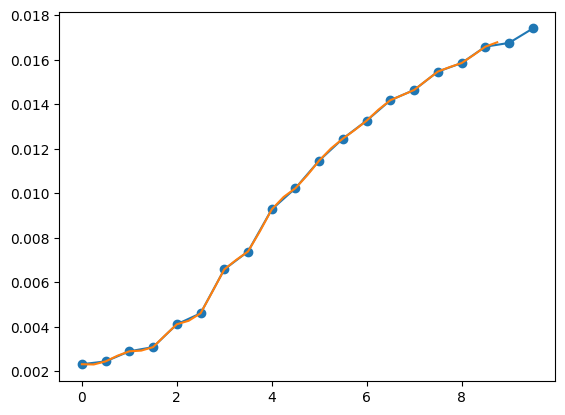

In [15]:

resolution = 2
tau = 0.5


# assume we supply full  forward rate curve with len = len(df)
df_init = create_df_init(df_cap, df_raw_spot, resolution=resolution, tau=tau)
def interp_func_fac(df_init, resolution=2, tau=0.5):

    df = df_init
    #fwd = df['Forward'].values # only used for test, not to be uncommented

    i_s = df['i_s'].values[:-resolution]
    i_sp1 = df['i_sp1'].values[:-resolution]
    i_e = i_sp1

    s = np.arange(len(df)-resolution)
    print("len s",len(s))
    e = s + resolution

    theta = (df['mod_accrual'].values)
    gamma = (df['gamma'].values)
    gamma_theta = gamma * theta

    print(f"{len(i_s)}, {len(i_e)}")



    def get_interp_rates(fwd):
        canon_rates = 1/(1+fwd[i_sp1]*tau)
        p_s_e = (1 + fwd[i_e] * gamma_theta[e]) / (1 + fwd[i_s] * gamma_theta[s]) * canon_rates
        f_s_e = (1 / p_s_e - 1) / tau 
        return f_s_e
    return get_interp_rates





fwd_tenor = df_init[['Forward', 'Tenor']].dropna().values

tenors = fwd_tenor[:,1]
fwd_rates = fwd_tenor[:,0]
interp_func: callable = interp_func_fac(df_init)
fwd_new = interp_func(df_init['Forward'].values)
print(len(fwd_new), len(df_init))
plt.plot(tenors, fwd_rates, 'o-')
plt.plot(np.arange(len(fwd_new))*tau/resolution,fwd_new)


In [16]:











#(1 + f_e * theta_e) / (1 + f_s * theta_s) * canon_rates

#print(fwd_i_s)



# =================================================================



# =============================================================================
#                         create swap rate weights
# =============================================================================
def get_semiannual_tenors_relative(start, tenor):
    end = start + tenor
    # Start at start + 0.5, step by 0.5, go up to and including end
    return np.arange(start + 0.5, end + 1e-8, 0.5)

def float_safe_mask(df_tenors, target_tenors, atol=1e-8):
    mask = np.zeros_like(df_tenors, dtype=bool)
    for t in target_tenors:
        mask |= np.isclose(df_tenors, t, atol=atol)
    return mask


def swap_weights(start, df,resolution, tau = 0.5, tenor=2):
    # Compute end of swap

    # Get semiannual cash flow times relative to swap start
    semi_tenors = get_semiannual_tenors_relative(start, tenor)
    #print(f"start: {start}, end: {semi_tenors[-1]}")
    #print(f"start of swap: {start}")
    #print(f"weight tenors (should be 0.5 ahead of forward rate tenors): {semi_tenors=}")
    # Filter to only those tenor points in the DataFrame
    mask = float_safe_mask(df["Tenor"].values, semi_tenors)

    #print(mask, df.loc[mask, 'Tenor'])
    print(np.arange(39)[mask])
    time_to_idx = int(resolution/tau)
    print(np.arange(start*resolution, start+tenor*resolution))
    
    # Pull corresponding zero-coupon prices and annuity weights
    zcb = df.loc[mask, 'zcb']


    print(mask)
    af = 0.5
    # Compute swap annuity and weights
    annuity = (zcb * tau).sum()
    weights = (zcb * tau) / annuity
    # Assert normalization
    assert np.isclose(weights.sum(), 1), "Swap weights do not sum to 1, its is {}".format(weights.sum())

    return weights




def get_swap_rate (start, df, tenor=2, resolution=2, tau =0.5):
    start = int(0.25/tau * resolution)+resolution
    
    return 

#def get_frozon_Ws()

def get_all_swaps(df,interp_funcs, tenor=2):
    starts = df['Tenor'][:-(tenor*12*2)].values
    
    #print(starts)
    swap_rates = [get_swap_rate(start, df, interp_funcs, tenor) for start in starts]
    #plt.plot(starts+1, swap_rates)
    #plt.plot(df['Tenor'].loc[df['Forward'].dropna().index],df['Forward'].dropna())
    return swap_rates, starts
 




In [ ]:
print(resolution)
swap_weights(0.25, df_init, resolution=2)

2.0
[3 5 7 9]
[0.5 1.5 2.5 3.5]
[False False False  True False  True False  True False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]


3    0.250549
5    0.250211
7    0.249845
9    0.249395
Name: zcb, dtype: float64

In [97]:
offset_yr = int(resolution/tau)
offset_semiannual = int(offset_yr/2)
t= 0


df_init[t+offset_yr:]


,Tenor,zcb,Forward,i_s,i_sp1,mod_accrual,gamma
4,1.00,0.997623,0.002898,4,6,0.50,1.000000
5,1.25,0.996913,NaN,4,6,0.25,1.016732
6,1.50,0.996179,0.003086,6,8,0.50,1.000000
7,1.75,0.995455,NaN,6,8,0.25,1.056449
8,2.00,0.994644,0.004112,8,10,0.50,1.000000
9,2.25,0.993663,NaN,8,10,0.25,1.037838
10,2.50,0.992604,0.004604,10,12,0.50,1.000000
11,2.75,0.991545,NaN,10,12,0.25,1.071626
12,3.00,0.990324,0.006580,12,14,0.50,1.000000
13,3.25,0.988787,NaN,12,14,0.25,1.053713


In [584]:
zcbs = df_init['zcb'].values

np.lib.stride_tricks.sliding_window_view(zcbs, window_shape=4)

df2 = df_init.copy()
print(len(df2))
#df2.loc[:-3,['w1','w2','w3','w4']] = 


def get_frozen_weight_func(resolution, tau, df, tenor=2):
    zcbs =df['zcb'].values # returns 2y swap rate
    swap_weights = np.lib.stride_tricks.sliding_window_view(zcbs, window_shape=tenor)*tau
    swap_weights = swap_weights/swap_weights.sum(axis=1)[:, np.newaxis]
    def swap_weights_frozen(t, expiry, forwards):
        offset = t+int(resolution/tau*expiry)
        #print(offset, resolution)
        #for fwd in forwards[offset:offset+4*resolution:resolution]:
        #    print(fwd)
        return np.dot(swap_weights[t+int(resolution/tau*expiry)], forwards[offset:offset+tenor*resolution:resolution])
    return swap_weights_frozen

swap_rate_func = get_frozen_weight_func(2, 0.5, df_init)
for i in range(50000):
    swap_rate_func(2, 2, df_init['Forward'].values)

39


In [19]:
df_init

,Tenor,zcb,Forward,i_s,i_sp1,mod_accrual,gamma
0,0.00,1.000000,0.002318,0,2,0.50,1.000000
1,0.25,0.999410,NaN,0,2,0.25,0.980943
2,0.50,0.998842,0.002445,2,4,0.50,1.000000
3,0.75,0.998259,NaN,2,4,0.25,1.043539
4,1.00,0.997623,0.002898,4,6,0.50,1.000000
5,1.25,0.996913,NaN,4,6,0.25,1.016732
6,1.50,0.996179,0.003086,6,8,0.50,1.000000
7,1.75,0.995455,NaN,6,8,0.25,1.056449
8,2.00,0.994644,0.004112,8,10,0.50,1.000000
9,2.25,0.993663,NaN,8,10,0.25,1.037838


ts_fwd_interp=array([0.   , 0.019, 0.038, 0.058, 0.077, 0.096, 0.115, 0.135, 0.154, 0.173, 0.192, 0.212, 0.231, 0.25 , 0.269, 0.288, 0.308, 0.327, 0.346, 0.365, 0.385, 0.404, 0.423, 0.442, 0.462, 0.481, 0.5  , 0.519, 0.538, 0.558, 0.577, 0.596, 0.615, 0.635, 0.654, 0.673, 0.692, 0.712, 0.731, 0.75 , 0.769, 0.788, 0.808, 0.827, 0.846, 0.865, 0.885, 0.904, 0.923, 0.942, 0.962, 0.981, 1.   , 1.019, 1.038, 1.058, 1.077, 1.096, 1.115, 1.135, 1.154, 1.173, 1.192, 1.212, 1.231, 1.25 , 1.269, 1.288, 1.308, 1.327, 1.346, 1.365, 1.385, 1.404, 1.423, 1.442, 1.462, 1.481, 1.5  , 1.519, 1.538, 1.558, 1.577, 1.596, 1.615, 1.635, 1.654, 1.673, 1.692, 1.712, 1.731, 1.75 , 1.769, 1.788, 1.808, 1.827, 1.846, 1.865, 1.885, 1.904, 1.923, 1.942, 1.962, 1.981, 2.   , 2.019, 2.038, 2.058, 2.077, 2.096, 2.115, 2.135, 2.154, 2.173, 2.192, 2.212, 2.231, 2.25 , 2.269, 2.288, 2.308, 2.327, 2.346, 2.365, 2.385, 2.404, 2.423, 2.442, 2.462, 2.481, 2.5  , 2.519, 2.538, 2.558, 2.577, 2.596, 2.615, 2.635, 2.654, 2.673,

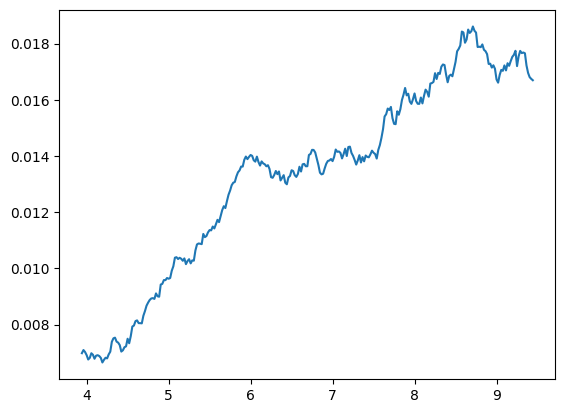

In [725]:


class LMMSABR():
    def __init__(self, rho_mat, theta_mat, phi_mat, g_params, h_params, epsilon_exp, s0_exp, yell=True):
        self.rho_mat = rho_mat
        self.theta_mat = theta_mat
        self.phi_mat = phi_mat
        self.g = partial(get_instant_vol_func, params=g_params)
        self.h = partial(get_instant_vol_func, params=h_params)
        self.epsilon_exp = epsilon_exp
        self.s0_exp = s0_exp
        if yell:
            print("h SHOULD PERHAPS BE FORCED TO BE POSITIVE")
    
    def creat_df_fwd_init(self):
        pass


    @staticmethod
    def getInstantaneousVolatility(t, expiry , params):
        '''
        Return the instantaneous volatility ,
        computed in terms of the parametric
        form proposed by Rebonato , at a given time t.
        @var t: time at which we want to compute the
        instantaneous volatility (in years)
        @var expiry: caplet expiry (in years)
        @var a: parameter a of Rebonato ’s instant. vol. function
        @var b: parameter b of Rebonato ’s instant. vol. function
        @var c: parameter c of Rebonato ’s instant. vol. function
        @var d: parameter d of Rebonato ’s instant. vol. function
        
        #g(T - t) & h(T - t)
        '''
        a,b,c,d = params
        tau = expiry - t
        instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
        return instantaneous_vol
    

    def zcb_price(self, t, T,S, forwards):
        pass

    def get_fwd_drift(self, t, f_t: np.ndarray):
        """find the drift of the forward rate given all longer maturity forwards"""
        pass
    def get_vol_drift(self, t, f_t):
        pass

    def simulate(self,resolution,max_expiry=9.5,  tau=0.5):
        df_init = create_df_init(df_cap, df_raw_spot, resolution=resolution, tau=tau).query(f"Tenor <= {max_expiry+1e-6}")

        ids_fwd_canon = df_init['Forward'].dropna().index.values
        num_sim = len(df_init)-1
        f_0 = df_init['Forward'].values
        num_forwards = df_init['Forward'].dropna().shape[0]
        tenors = df_init['Tenor'].values
        swap_tenor = 2
        interp_func = interp_func_fac(df_init, resolution=resolution, tau=tau)
        swap_weight_func = get_frozen_weight_func(resolution, tau, df_init, swap_tenor)

        self.tenors = tenors
        self.num_sim = num_sim+1
        self.resolution = resolution

        
        # so, we have 20 rates, and 1000 simulations, we must fill in the spot rates for each simulation. the spot rate for each simulation is f_sim[i,i] and so on, if we simulate months, the 6m forward is f_sim[i,i+6]
        # the number of steps must be a multiple of the number of tenors
        # since the intermediate rates (t + all_tenor)% len(tenors) != 0, depend on the previous rate, we point to the previous canon rate, using the function all_forwards[tenor](f_sim[i])





        # ==========================================================================
        #num_forwards = len(f_0) # including L(0,0,tau)
        



        dt = tau / resolution
        self.dt = dt
        #print(f"times per year = {resolution*tau}")
        dt_sqrt = math.sqrt(dt)

        ttm_mat = tenors[None,:]-tenors[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate
        f_sim = np.zeros(ttm_mat.shape)*np.nan # each simulation, we must have a spot rate

        f_sim[0] = f_0

        # =============================================================================
        #print(canon_indices[::-1])



        # precompute h and g
        #ttm_mat = tenors - t_arr.reshape(-1,1)
        #ttm_mat# [ttm_mat<0] = 0 # TODO: ENABLE THIS IF IT GOES WRONG
        h_mat = self.h(ttm_mat[1:, ids_fwd_canon])
        g_mat = self.g(ttm_mat[1:, ids_fwd_canon])

        # precompute random draws
        dZ_f = np.random.multivariate_normal(np.zeros(num_forwards), self.rho_mat[:num_forwards,:num_forwards], num_sim) * dt_sqrt
        dW_s = np.random.multivariate_normal(np.zeros(num_forwards), self.theta_mat[:num_forwards,:num_forwards], num_sim) * dt_sqrt
        # precompute all s_t
        # start by multiplying epsilon_exp with the random draws along the forwards on all timesteps
        s_mat = s0_exp[:num_forwards] * np.cumprod(1 + self.epsilon_exp[:num_forwards].reshape(1,-1) * dW_s * h_mat, axis=0)
        alpha_mat = g_mat * s_mat
        
        # we use Q^{T_j} measure, where j=len(tenors)-1, so the last tenor is a martingale.
        # we can compute the value of the last tenor directly from the s_mat values
        #print(ttm_mat)
        drift_correction = np.zeros(len(f_sim[0]))
        drift_shared = np.zeros(len(f_sim[0]))
        ids_fwd_canon_rev = ids_fwd_canon[::-1]
        ids_fwd_canon_short_rev = ids_fwd_canon_rev//resolution
        non_canon_indices = np.setdiff1d(np.arange(len(f_sim[0]))[:-resolution], ids_fwd_canon_rev)
        non_canon_idx = non_canon_indices
        f_list = []
        swap_expiry = 3
        swap_rate_1y2y = []
        swap_offset = int(resolution/tau*(swap_tenor*tau+swap_expiry)-3)
        swap_time = np.arange(swap_offset, num_sim)*dt
        self.swap_time = swap_time
        for i in range(10):
            f_sim = f_sim * np.nan
            f_sim[0] = f_0
            f_sim[0, non_canon_idx] = interp_func(f_sim[0])[non_canon_idx]
            swap_rate_1y2y = []
            swap_rate_1y2y.append(swap_weight_func(0, swap_expiry, f_sim[0]))
            for t in range(1, num_sim-swap_offset):
                drift_correction.fill(0)
                drift_shared.fill(0)
                # next loop runs from longest to shortest tenor
                for canon_short_idx, canon_idx in zip(ids_fwd_canon_short_rev, ids_fwd_canon_rev):
                    
                    if ttm_mat[t, canon_idx] +tau+1e-8>= 0:     # TODO <------------ THIS IS IMPORTANT
                        alpha_t, dZ_f_t,  f_t = alpha_mat[t-1, canon_short_idx], dZ_f[t-1,canon_short_idx], f_sim[t-1,canon_idx]
                        f_beta_t = f_t**0.5
                        drift_f = (-g_mat[t, canon_short_idx] * s_mat[t, canon_short_idx] * f_beta_t * drift_shared[canon_short_idx])
                        df_t =  drift_f + f_beta_t*alpha_t*dZ_f_t
                        f_t += df_t
                        
                        f_t_new =  f_t + df_t if f_t + df_t > 0 else 0  # zero absorbing boundary, interest rates cannot be negative due to arbitrage
                        f_sim[t,canon_idx] = f_t_new

                        if canon_short_idx > 0:
                            drift_correction[canon_short_idx-1] = self.rho_mat[canon_short_idx-1, canon_short_idx] * tau * g_mat[t,canon_short_idx] * s_mat[t, canon_short_idx] * f_beta_t / (1 + tau * f_t)
                            drift_shared[canon_short_idx-1] = np.sum(drift_correction[canon_short_idx-1:])
                

                    
                f_sim[t, non_canon_idx] = interp_func(f_sim[t])[non_canon_idx]
                
                swap_rate_1y2y.append(swap_weight_func(t, swap_expiry, f_sim[t]))
                
            
            self.f_sim = f_sim
            f_list.append(f_sim)
        self.f_list = f_list
        self.swap_rate_1y2y = swap_rate_1y2y
        return f_sim
    
    def plot(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Create mesh grid for x (time) and y (tenors)
        X = np.arange(self.num_sim)*self.dt
        Y = np.arange(self.num_sim-resolution)*self.dt
        X, Y = np.meshgrid(X, Y)
        
        # Transpose f_sim to match the grid shape
        Z = self.f_sim[:,:-resolution].T

        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Tenors')
        ax.set_zlabel('Forward Rates')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        plt.show()
         
lmm = LMMSABR(rho_mat_0m, theta_mat_0m, phi_mat, params_g, params_h, epsilon_exp, s0_exp=s0_exp, yell=False)
f_sim = lmm.simulate(resolution=26, max_expiry = 9.5)
#lmm.plot()
print(lmm.swap_time.shape)
print(len(lmm.swap_rate_1y2y))
plt.plot(lmm.swap_time,lmm.swap_rate_1y2y)

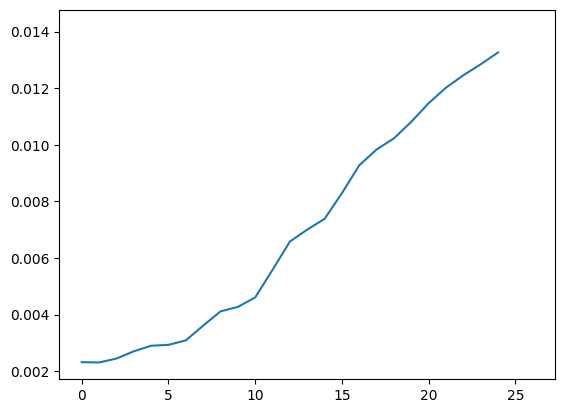

In [21]:
fsim = lmm.f_sim[0]
plt.plot(fsim)

ts_fwd_interp=array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667, 1.5       , 1.58333333,
       1.66666667, 1.75      , 1.83333333, 1.91666667, 2.        ,
       2.08333333, 2.16666667, 2.25      , 2.33333333, 2.41666667,
       2.5       , 2.58333333, 2.66666667, 2.75      , 2.83333333,
       2.91666667, 3.        , 3.08333333, 3.16666667, 3.25      ,
       3.33333333, 3.41666667, 3.5       , 3.58333333, 3.66666667,
       3.75      , 3.83333333, 3.91666667, 4.        , 4.08333333,
       4.16666667, 4.25      , 4.33333333, 4.41666667, 4.5       ,
       4.58333333, 4.66666667, 4.75      , 4.83333333, 4.91666667,
       5.        , 5.08333333, 5.16666667, 5.25      , 5.33333333,
       5.41666667, 5.5       , 5.58333333, 5.66666667, 5.75      ,
       5.83333333, 5.91666667, 6.        , 6.083

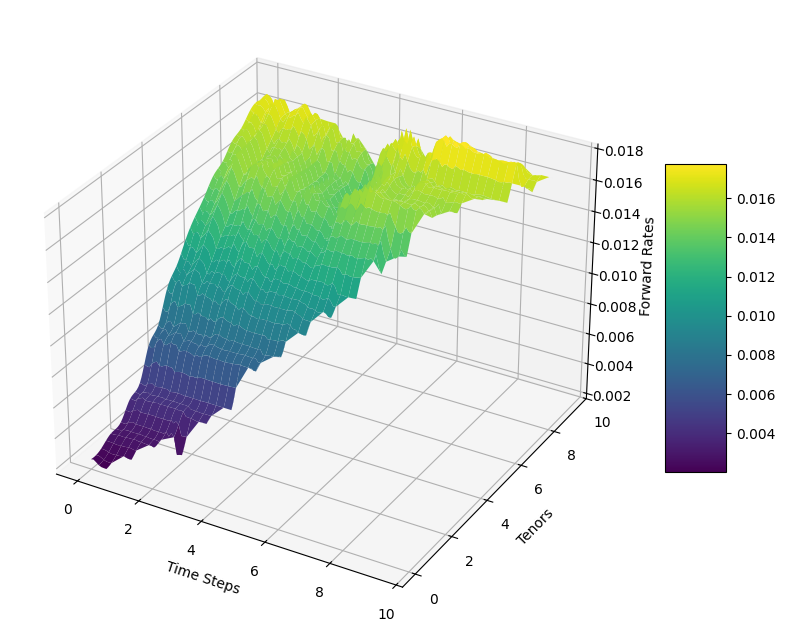

[[0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.005 0.005 0.006 0.006 0.006 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.008 0.009 0.009 0.009 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.011 0.011 0.011 0.011 0.011 0.012 0.012 0.012 0.012 0.012 0.012 0.013 0.013 0.013 0.013 0.013 0.013 0.013 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.017 0.017 0.017 0.017 0.017 0.017 0.017   nan   nan   nan   nan   nan 0.017]
 [0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.005 0.005 0.005 0.006 0.006 0.006 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.008 0.009 0.009 0.009 0.009

array([[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.005, 0.005, 0.005, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.007, 0.008, 0.008, 0.008, 0.009, 0.009, 0.009, 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.011, 0.011, 0.011, 0.011, 0.011, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.013, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017,   nan,   nan,   nan,   nan,   nan, 0.017],
       [0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.0

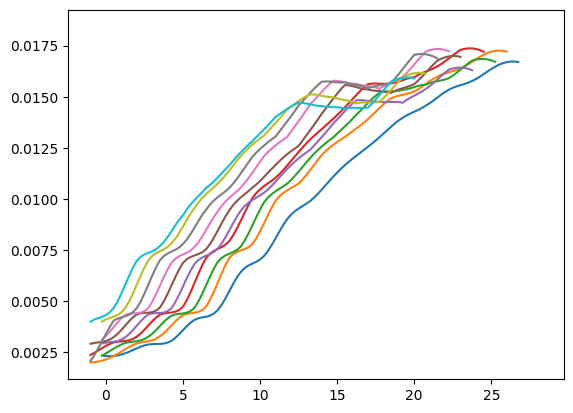

In [22]:

#for i in range(1000):
f_sim = lmm.simulate(resolution=6)
#print(lmm.tenors)
#print(lmm.h(0.1))

#print()
lmm.plot()

#plt.hist(lmm.f_sim[:,-1], bins=100)
lmm.f_sim
# print pretty formatted matrix
np.set_printoptions(precision=3, suppress=True)
# make matrix wider
np.set_printoptions(linewidth=2000)
# print full matrix, no shortening
np.set_printoptions(threshold=np.inf)
print(lmm.f_sim)
#print(np.hstack((lmm.time_grid.reshape(-1,1), 100*lmm.f_sim)))
for i in range(1,30, 3):
    print(lmm.f_sim[i].size)
    plt.plot((np.arange(lmm.f_sim[i].size)-i)*0.25, lmm.f_sim[i])
f_sim

In [23]:

# Parameters

tau = 1
resolution = 2 / tau
num_forwards = 5 # including L(0,0,tau)



dt = tau / resolution
steps_per_year  = resolution * tau



# Tenor grid
ts_fwd_expiry = np.arange(num_forwards) * tau  # [0.0, 0.5, 1.0, ...]
ids_fwd_canon = (ts_fwd_expiry*resolution).astype(int)


# Time grid
T_max = ts_fwd_expiry[-1]
ts_fwd_expiry_interp = np.arange(0, T_max + dt, dt)  # [0.0, 0.25, ..., T_max]
assert ts_fwd_expiry_interp[-1] == T_max, "Time grid does not end at the beginning of the last forward"
ttm_matrix = ts_fwd_expiry_interp[None,:]-ts_fwd_expiry_interp[:,None] # each row is a time increment, and each column represents the time to maturity of a forward rate


In [24]:
# pull out simulation, then do the swap stuff

In [25]:
#define arguments to use for LMM SABR Simulation
no_of_sim = 2 #change this
steps_per_year = 20
F_0 = forwards #from caplet_fitting.py
s_0 = s0_exp #from caplet_fitting.py
epsilon = epsilon_exp #from caplet_fitting.py
corr_fwd_fwd_full_rank = doust_fwd_fwd[:19, :19]
corr_vol_vol_full_rank = doust_vol_vol[:19, :19]
corr_fwd_vol = corr_fwd_vol #from caplet_fitting.py
no_of_factors = 6 #correlation factors reduce rank
beta = np.repeat(0.5, len(F_0))
tau = 0.5 #semi-annual forwards
fixing_time_grid = np.arange(1,20)/2
print(fixing_time_grid)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.  9.5]


In [26]:
simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                          fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                          epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                          corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                          corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                          beta = beta, tau = tau, params_g = params_g, params_h = params_h)

plt.plot(simulated_fwd_full[:,:,1].T)
plt.show()

NameError: name 'simulateSABRLMM' is not defined

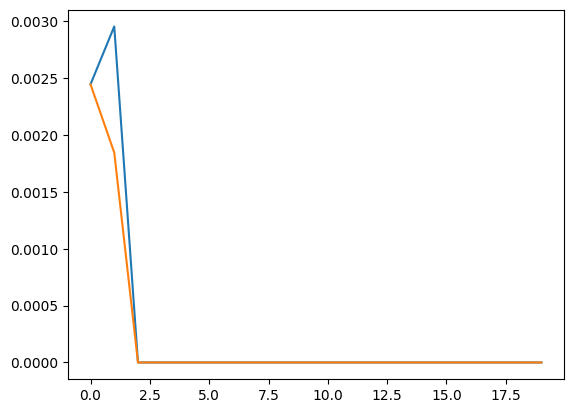

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

# Given function definitions
def g_tau(tau, a, b, c, d):
    """eq 2, also the function for sigma_i(tau_i)"""
    val = (a + b * tau) * np.exp(-c * tau) + d
    return np.maximum(val, 1e-6)

def h_tau(tau, ah, bh, gamma, delta):
    """eq 19, also the function for nu_i(tau_i) (volatility of volatility)"""
    val = (ah + bh * tau) * np.exp(-gamma * tau) + delta
    return np.maximum(val, 1e-6)

# Integral of g^2 over [0, T]
def g_hat(T, a, b, c, d):
    integral, _ = quad(lambda tau: g_tau(tau, a, b, c, d) ** 2, 0, T)
    return np.sqrt(integral / T)

# Integral of h^2 over [0, T]
def h_hat(T, ah, bh, gamma, delta):
    integral, _ = quad(lambda tau: h_tau(tau, ah, bh, gamma, delta) ** 2, 0, T)
    return np.sqrt(integral / T)




def initial_vol(rho_arr, W_arr, k_0_arr, g_tau_arr, T):
    """
    Computes the initial volatility Σ₀ using equation (63).

    Parameters:
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - T: (float) Maturity time T.

    Returns:
    - Σ₀: (float) The initial volatility term.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j dt
    integral_g = np.trapz(g_tau_arr @ g_tau_arr.T, dx=T / g_tau_arr.shape[1])
    
    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += rho_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_g[i, j]
    
    # Compute Σ₀
    Sigma_0 = np.sqrt((1 / T) * sum_term)
    
    return Sigma_0

initial_vol()

import numpy as np

def compute_V(Sigma_0, rho_arr, theta_arr, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, T):
    """
    Computes V using the given formula.

    Parameters:
    - Sigma_0: (float) Initial volatility term Σ₀.
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - theta_arr: (numpy array) Additional correlation matrix θ_ij.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - T: (float) Maturity time T.

    Returns:
    - V: (float) The computed volatility term V.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += 2 * rho_arr[i, j] * theta_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
    
    # Compute V
    V = (1 / (Sigma_0 * T)) * np.sqrt(sum_term)
    
    return V

import numpy as np

def compute_Omega(rho_mat, phi_mat, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, V, Sigma_0, T):
    """
    Computes Ω_ij using equation (76).

    Parameters:
    - rho_mat: (numpy array) Correlation matrix ρ_ij of forward rates.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - V: (float) Computed volatility term from equation (previous).
    - Sigma_0: (float) Initial volatility term.
    - T: (float) Maturity time.

    Returns:
    - Omega_mat: (numpy array) Matrix of Ω_ij values.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute Ω_ij matrix
    Omega_mat = np.zeros((no_of_fwds, no_of_fwds))
    denominator = (V * Sigma_0 * T) ** 2  # (V Σ₀ T)²
    
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            numerator = 2 * rho_mat[i, j] * phi_mat[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
            Omega_mat[i, j] = numerator / denominator
    
    return Omega_mat


import numpy as np

def compute_Phi(Omega_mat, phi_mat, atol=1e-6):
    """
    Computes Φ using equation (78) and verifies Ω_ij constraints.

    Parameters:
    - Omega_mat: (numpy array) Weighting matrix Ω_ij.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - Phi: (float) The computed Φ value.
    """
    # Check that Ω_ij >= 0
    if np.any(Omega_mat < -atol):  # Allow small numerical noise
        raise ValueError("Error: Some elements in Omega_mat are negative!")

    # Check that sum of Ω_ij is close to 1
    Omega_sum = np.sum(Omega_mat)
    if not np.isclose(Omega_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of Ω_ij is {Omega_sum}, expected 1.0")

    # Compute Φ as the weighted sum of Ω_ij * φ_ij
    Phi = np.sum(Omega_mat * phi_mat)
    
    return Phi

import numpy as np

def compute_B(w_arr, beta_arr, atol=1e-6):
    """
    Computes B using equation (79), ensuring w_k acts as valid weights.

    Parameters:
    - w_arr: (numpy array) Weight vector w_k, corresponding to the swap periods.
    - beta_arr: (numpy array) Corresponding beta values β_k for each period.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - B: (float) The computed exponent B.
    """
    # Truncate arrays to match the running time of the swap
    w_arr = w_arr
    beta_arr = beta_arr

    # Ensure w_k are valid weights (sum to 1)
    w_sum = np.sum(w_arr)
    if not np.isclose(w_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of w_k is {w_sum}, expected 1.0")

    # Compute B as the weighted sum over the swap's running period
    B = np.sum(w_arr * beta_arr)
    
    return B

